In [6]:
from transformers import pipeline
import requests
import time
import torch
import numpy as np
import cv2
from PIL import Image
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [12]:
# load pipe
pipe = pipeline(task="depth-estimation", model="depth-anything/Depth-Anything-V2-Small-hf")

/home/qiao/miniconda3/envs/tag/lib/python3.9/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [7]:
image = Image.open('Kitti/training/image_2/000000_00.png')

In [20]:
start = time.time()
depth = pipe(image)["depth"]
end = time.time()
print(f'Time cost: {end - start}s')

Time cost: 2.4114091396331787s


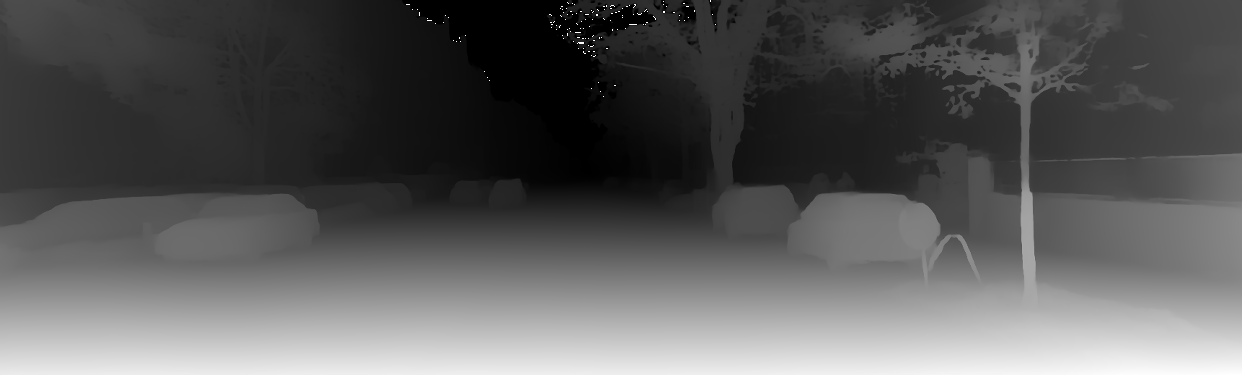

In [15]:
depth

In [16]:
depth.mode

'L'

In [17]:
type(image)

PIL.PngImagePlugin.PngImageFile

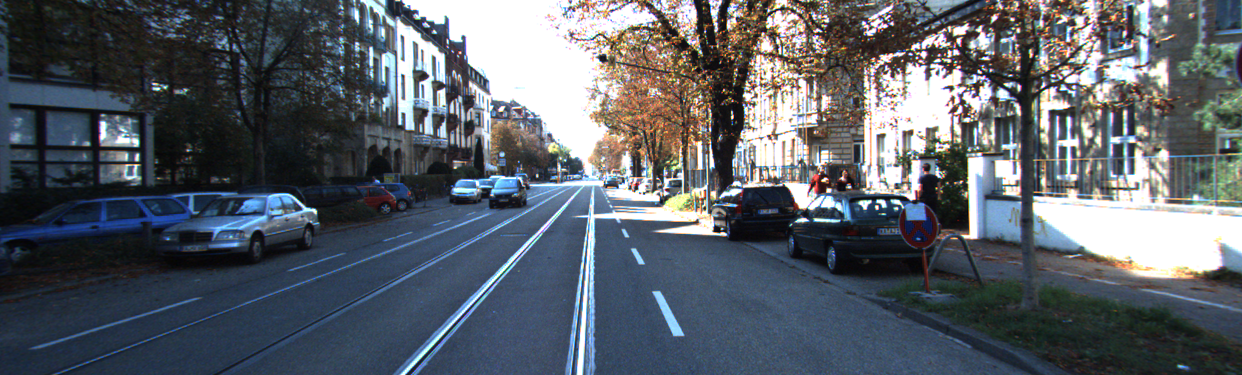

In [18]:
image

In [22]:
def depth_to_point_cloud_gpu(rgb_image_path, depth_image_pil, fx, fy, cx, cy, device='cuda'):
    """
    将 RGB 图像与深度图转换为点云，利用 GPU 加速计算
    :param rgb_image_path: RGB 图像的路径
    :param depth_image_pil: PIL.Image 格式的深度图
    :param fx, fy: 相机的焦距，单位为像素
    :param cx, cy: 相机的主点，单位为像素
    :param device: 设备 ('cuda' 或 'cpu')
    :return: 点云对象
    """
    # 读取 RGB 图像
    rgb_image = Image.open(rgb_image_path)
    rgb_image = np.array(rgb_image)
    rgb_image = torch.from_numpy(rgb_image).float().to(device) / 255.0  # 归一化到 [0, 1]

    # 将 PIL 图像转换为 numpy 数组
    depth_image = np.array(depth_image_pil).astype(np.float32)

    # 将深度图转换为 torch tensor，并转到指定设备（GPU 或 CPU）
    depth_image = torch.from_numpy(depth_image).to(device)

    # 获取图像的高度和宽度
    height, width = depth_image.shape

    # 创建网格坐标 (u, v)，形状为 (H, W)
    u, v = torch.meshgrid(torch.arange(width, device=device), torch.arange(height, device=device))
    u = u.reshape(-1)
    v = v.reshape(-1)

    # 获取深度图的每个像素的深度值 Z
    Z = depth_image.reshape(-1)

    # 根据相机的内参计算三维点坐标
    X = (u - cx) * Z / fx
    Y = (v - cy) * Z / fy

    # 将 RGB 图像的每个像素颜色映射到点云
    color = rgb_image[v, u]

    # 将 3D 坐标 (X, Y, Z) 和颜色组合成一个点云
    points = torch.stack([X, Y, Z], dim=1)
    points = points[Z > 0]  # 过滤掉深度为 0 的点

    colors = color[Z > 0]

    # 将结果转换为 numpy 数组
    points = points.cpu().numpy()
    colors = colors.cpu().numpy()

    # 创建 Open3D 点云对象
    point_cloud = o3d.geometry.PointCloud()
    point_cloud.points = o3d.utility.Vector3dVector(points)
    point_cloud.colors = o3d.utility.Vector3dVector(colors)

    return point_cloud


# 假设的相机内参
fx = 1000.0  # 焦距
fy = 1000.0  # 焦距
cx = 1275 / 2  # 主点 x 坐标
cy = 375 / 2  # 主点 y 坐标

In [23]:
# 示例图片路径和深度图
rgb_image_path = 'Kitti/training/image_2/000000_00.png'  # 替换为你的 RGB 图像路径
depth_image_pil = depth  # 替换为你的深度图路径

# 使用 GPU 加速转换为点云
point_cloud = depth_to_point_cloud_gpu(rgb_image_path, depth_image_pil, fx, fy, cx, cy)

# 可视化点云
o3d.visualization.draw_geometries([point_cloud])

/home/qiao/miniconda3/envs/tag/lib/python3.9/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [24]:
pipe_out = pipe(image)

In [26]:
type(pipe_out['predicted_depth'])

torch.Tensor

In [30]:
pipe_out['predicted_depth'].max()

tensor(9.0981)

In [8]:
import os
from torchvision import transforms

In [5]:
os.path.splitext('a.py')[0]

'a'

In [ ]:
os.path.basename('a/preprocess.py')

'preproccess.py'

In [11]:
# 加载和调整图像大小
transform_resize = transforms.Resize((240, 432))
image = transform_resize(image.convert("RGB"))

In [14]:
image.size

(432, 240)

In [15]:
size = (432, 240)

In [16]:
w, h = size

In [17]:
w

432